In [31]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import random
from random import randint
from rdkit.Chem import Draw
from rdkit import DataStructs
import sklearn as sk
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import matplotlib as mpl
mpl.rcParams['font.family']='serif'
mpl.rcParams['mathtext.fontset']='cm'
import matplotlib.pyplot as plt
#import tensorflow as tf
from sklearn.model_selection import learning_curve
import re

#Import error metric
from sklearn.metrics import mean_squared_error

#Import a dataset
from sklearn.datasets import load_boston

#Import data munging tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

%matplotlib inline

In [64]:
data = pd.read_csv("Diarylethenes_Isomers2.csv", sep=',',header=0)
data = data.dropna()

In [ ]:
data2 = pd.read_csv("Diarylethenes_Isomersunique_0.txt", sep=',',header=None,names=["TRANS","CIS","CODE","E"])
data2 = data2.dropna()
for i in range(34):
    diar_data = pd.read_csv("Diarylethenes_Isomersunique_{}.txt".format(i), sep=',',header=None,names=["TRANS","CIS","CODE","E"])
    diar_data = diar_data.dropna()
    data2 = pd.concat([data2, diar_data])

# Distribution of energy difference

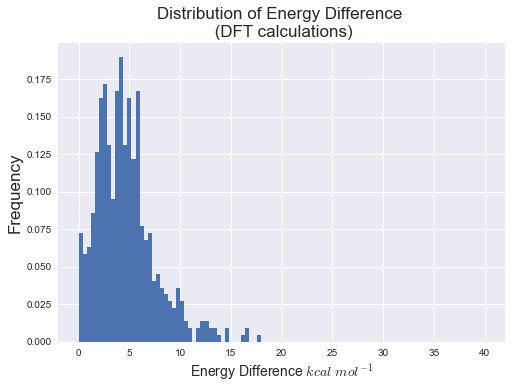

In [150]:
plt.style.use('seaborn')
plt.hist(data2["E"],bins=100,range=(0,40),density=True)
plt.ylabel('Frequency',fontsize=17)
plt.xlabel('Energy Difference $kcal$ $mol^{-1}$',fontsize=14)
plt.title('Distribution of Energy Difference \n (DFT calculations)',fontsize=17)
plt.show()

In [33]:
data


,num,TRANS,CIS,CODE,diff check,rdkit charge E,rdkit charge Z,chrg check,xtb SP E,xtb SP Z,E
1,2,Fc1ccccc1/C=C/c1nn2c(-c3cccnc3)nnc2s1,Fc1ccccc1\C=C/c1nn2c(-c3cccnc3)nnc2s1,MolPort-005-444-628,False,0.0,0.0,True,-61.874681,-61.873308,0.86145155
2,3,O=c1[nH]c(/C=C/c2cn(Cc3ccccc3)c3ccccc23)nc2ccc...,O=c1[nH]c(\C=C/c2cn(Cc3ccccc3)c3ccccc23)nc2ccc...,MolPort-005-444-633,False,0.0,0.0,True,-76.043220,-76.034585,5.418813865
3,4,FC(F)Oc1ccccc1/C=C/c1nc2ccccc2s1,FC(F)Oc1ccccc1\C=C/c1nc2ccccc2s1,MolPort-005-475-781,False,0.0,0.0,True,-59.535958,-59.526916,5.673609023
5,6,O=C(CCCN1C(=O)c2ccccc2C1=O)Oc1ccc(/C=C/c2ccccn...,O=C(CCCN1C(=O)c2ccccc2C1=O)Oc1ccc(\C=C/c2ccccn...,MolPort-005-475-783,False,0.0,0.0,True,-85.790068,-85.785896,2.618042307
7,8,COc1ccccc1/C=C/c1cc(C)no1,COc1ccccc1\C=C/c1cc(C)no1,MolPort-005-478-099,False,0.0,0.0,True,-45.438438,-45.433664,2.996099617
...,...,...,...,...,...,...,...,...,...,...,...
46646,46647,CS(=O)c1ccc(/C=C/c2cc(=O)c3ccccc3o2)cc1,CS(=O)c1ccc(\C=C/c2cc(=O)c3ccccc3o2)cc1,eMolecules-nan,False,0.0,0.0,True,-61.028942,-61.021442,4.706192142
46647,46648,COc1ccc(/C=C/c2nc(-c3cccnc3)no2)cc1OC,COc1ccc(\C=C/c2nc(-c3cccnc3)no2)cc1OC,eMolecules-nan,False,0.0,0.0,True,-64.926839,-64.917649,5.766593932
46649,46650,O=c1c2ccccc2nc(/C=C/c2c[nH]c3ccccc23)n1-c1ccc(...,O=c1c2ccccc2nc(\C=C/c2c[nH]c3ccccc23)n1-c1ccc(...,eMolecules-nan,False,0.0,0.0,True,-76.942592,-76.934543,5.050588242
46650,46651,Fc1ccc(/C=C/c2cc(-c3ccc(F)cc3)nc3cc4c(cc23)OCO...,Fc1ccc(\C=C/c2cc(-c3ccc(F)cc3)nc3cc4c(cc23)OCO...,eMolecules-nan,False,0.0,0.0,True,-79.525090,-79.518563,4.096261204


# Morgan Fingerprint optimization

In [75]:
data["mol"] = [Chem.MolFromSmiles(x) for x in data["CIS"]]
data["morg_fp"] = [AllChem.GetMorganFingerprintAsBitVect(m, 4, nBits = 2048) for m in data['mol']]

morg_fp = [AllChem.GetMorganFingerprintAsBitVect(m, 4, nBits = 2048) for m in data['mol']]

morg_fp_np = []
for fp in morg_fp:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    morg_fp_np.append(arr)

In [76]:
X = morg_fp_np
y = data["E"].astype(float).tolist()
m = len(y)

In [77]:
m

31421

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train0 = scaler.fit_transform(X_train)
X_test0 = scaler.transform(X_test)

In [79]:
lasso = SelectFromModel(linear_model.Lasso(normalize= True,alpha= 0.0015)) #normalize= True,
lasso.fit(X_train0, y_train)
X_train = lasso.transform(X_train0)
X_test = lasso.transform(X_test0)

In [80]:
print(np.shape(X_train))
print(np.shape(X_test))

(25136, 103)
(6285, 103)


In [59]:
index = [16,32,64,96,128,160,192,224,256,288,320,352,384,416,448,512,576,640,704,768,896,1024,2048]
#index=[2048]
MSE = []
nBits = []
for i in index:
    azo_data["mol"] = [Chem.MolFromSmiles(x) for x in azo_data["CIS"]]
    azo_data["morg_fp"] = [AllChem.GetMorganFingerprintAsBitVect(m, 4, nBits = i) for m in azo_data['mol']]

    morg_fp = [AllChem.GetMorganFingerprintAsBitVect(m, 4, nBits = i) for m in azo_data['mol']]

    morg_fp_np = []
    for fp in morg_fp:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        morg_fp_np.append(arr)
    X = morg_fp_np
    y = azo_data["E"].astype(float).tolist()
    m = len(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lasso = SelectFromModel(linear_model.Lasso(normalize= True, alpha= 0.0015))
    lasso.fit(X_train, y_train)
    X_train = lasso.transform(X_train)
    X_test = lasso.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_predict = lr.predict(X_test)
    MSE.append(sk.metrics.mean_squared_error(y_test, y_predict))
    nBits.append(i)

min_index = MSE.index(np.min(MSE))
print('Minimum MSE:', np.min(MSE))
print('Optimum nBit Value:', nBits[min_index])

Minimum MSE: 52.873518878083054
Optimum nBit Value: 2048


Text(0.5, 1.03, '$Linear$ $Regression$ $Mean$ $Squared$ $Error$ $by$ \n $Morgan$ $Fingerprint$ $Bit$ $Vector$ $Size$ $(\\alpha=0.0015,$ $r=4)$')

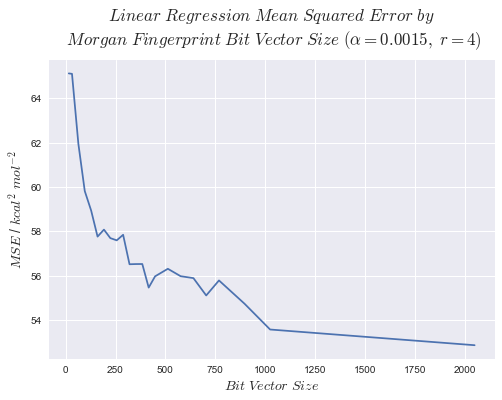

In [60]:
plt.style.use('seaborn')
plt.plot(index, MSE)
plt.ylabel(r'$MSE$ / $kcal^{2}$ $mol^{-2}$', fontsize = 14)
plt.xlabel('$Bit$ $Vector$ $Size$', fontsize = 14)
plt.title('$Linear$ $Regression$ $Mean$ $Squared$ $Error$ $by$ \n $Morgan$ $Fingerprint$ $Bit$ $Vector$ $Size$ ' r'$(\alpha=0.0015,$ $r=4)$', fontsize = 17, y = 1.03)

In [61]:
index = [1,2,3,4,5,6,7,8,9,10]
MSE = []
morgan_radius = []
for i in index:
    azo_data["mol"] = [Chem.MolFromSmiles(x) for x in azo_data["CIS"]]
    azo_data["morg_fp"] = [AllChem.GetMorganFingerprintAsBitVect(m, i, nBits = 2048) for m in azo_data['mol']]

    morg_fp = [AllChem.GetMorganFingerprintAsBitVect(m, i, nBits = 2048) for m in azo_data['mol']]

    morg_fp_np = []
    for fp in morg_fp:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        morg_fp_np.append(arr)
    X = morg_fp_np
    y = azo_data["E"].astype(float).tolist()
    m = len(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lasso = SelectFromModel(linear_model.Lasso(normalize= True, alpha= 0.0015))
    lasso.fit(X_train, y_train)
    X_train = lasso.transform(X_train)
    X_test = lasso.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_predict = lr.predict(X_test)
    MSE.append(sk.metrics.mean_squared_error(y_test, y_predict))
    morgan_radius.append(i)

min_index = MSE.index(np.min(MSE))
print('Minimum MSE:', np.min(MSE))
print('Optimum Radius Value:', morgan_radius[min_index])

Minimum MSE: 52.873518878083054
Optimum Radius Value: 4


Text(0.5, 1.03, '$Linear$ $Regression$ $Mean$ $Squared$ $Error$ $by$ \n $Morgan$ $Fingerprint$ $Function$ $Radius$ $Value$ $(nbits=2048, $$\\alpha=0.0015)$')

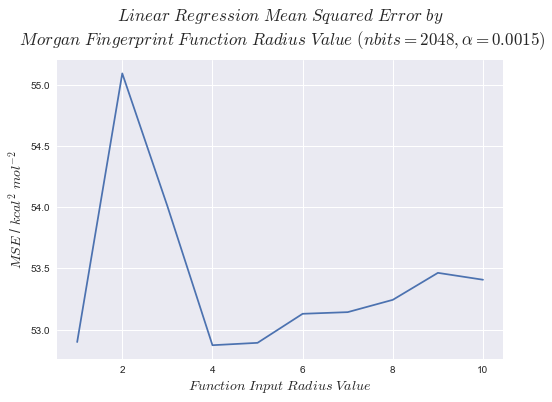

In [63]:
plt.style.use('seaborn')
plt.plot(index, MSE)
plt.ylabel('$MSE$ / $kcal^{2}$ $mol^{-2}$', fontsize = 14)
plt.xlabel('$Function$ $Input$ $Radius$ $Value$', fontsize = 14)
plt.title('$Linear$ $Regression$ $Mean$ $Squared$ $Error$ $by$ \n $Morgan$ $Fingerprint$ $Function$ $Radius$ $Value$ $(nbits=2048, $' r'$\alpha=0.0015)$', \
fontsize = 17, y = 1.03)

# Linear Regression

In [81]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

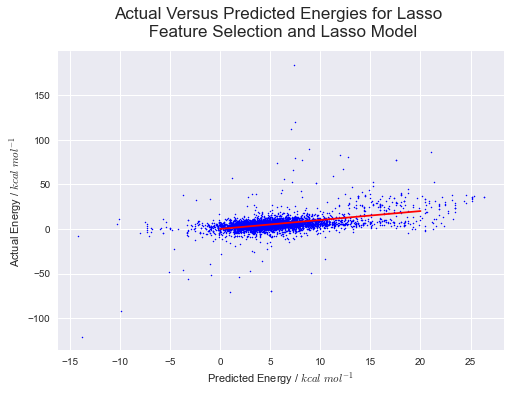

In [82]:
plt.style.use('seaborn')
plt.plot(y_predict, y_test, 'b.', markersize = 3)
plt.title('Actual Versus Predicted Energies for Lasso \n Feature Selection and Lasso Model', \
          fontsize = 17, y = 1.03)
plt.xlabel('Predicted Energy / $kcal$ $mol^{-1}$')
plt.ylabel('Actual Energy / $kcal$ $mol^{-1}$')
x = np.linspace(0,20)
plt.plot(x, x, 'r')
plt.ylim([0, 35])
plt.xlim([0, 17])
plt.savefig('Lasso_opt.png')

In [199]:
print('Mean Squared Error:', sk.metrics.mean_squared_error(y_test, y_predict))
print('Mean Absolute Error:', sk.metrics.mean_absolute_error(y_test, y_predict))
print('Mean Absolute Value:', (np.sum(y_test)/np.size(y_test)))

Mean Squared Error: 55.31220592224759
Mean Absolute Error: 3.819284310030812
Mean Absolute Value: 5.460541777339284


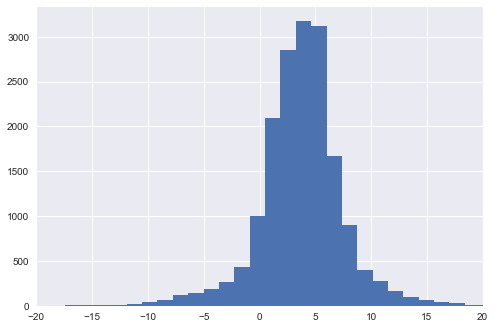

In [231]:
plt.style.use('seaborn')
plt.hist(y_train,bins=400)
plt.xlim(-20,20)
plt.show()

In [90]:
train_sizes, train_scores, validation_scores = learning_curve(estimator=LinearRegression(), X=X_train, y=y_train, \
train_sizes = [2000,4000,6000,8000,10000,12000,14000,16000,18000,20000], cv = 5, scoring = 'neg_mean_squared_error')

In [91]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

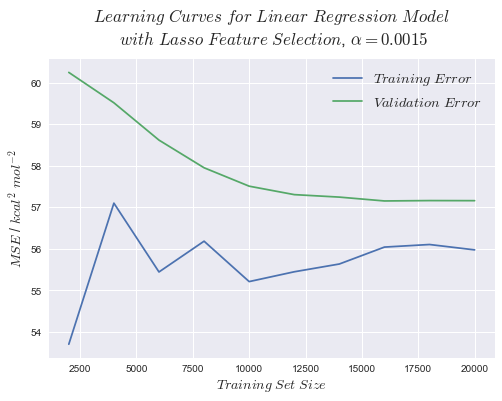

In [93]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = '$Training$ $Error$')
plt.plot(train_sizes, validation_scores_mean, label = '$Validation$ $Error$')
plt.ylabel('$MSE$ / $kcal^{2}$ $mol^{-2}$', fontsize = 14)
plt.xlabel('$Training$ $Set$ $Size$', fontsize = 14)
plt.title('$Learning$ $Curves$ $for$ $Linear$ $Regression$ $Model$ \n $with$ $Lasso$ $Feature$ $Selection$, ' r'$\alpha = 0.0015$', fontsize = 17, y = 1.03)
plt.legend(fontsize='x-large')
plt.savefig('training_curves.png',bbox_inches='tight',pad_inches=0.2)

# Hyperparameter optimization

In [96]:
index = np.linspace(0.0005,0.005)

MSE = []
Alpha = []
for i in index:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    lasso = SelectFromModel(linear_model.Lasso(normalize= True, alpha= i))
    lasso.fit(X_train, y_train)
    X_train = lasso.transform(X_train)
    X_test = lasso.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_predict = lr.predict(X_test)
    MSE.append(sk.metrics.mean_squared_error(y_test, y_predict))
    Alpha.append(i)

min_index = MSE.index(np.min(MSE))
print('Minimum MSE:', np.min(MSE))
print('Optimum Alpha Value:', Alpha[min_index])

Minimum MSE: 51.731869762799285
Optimum Alpha Value: 0.0006836734693877551


Text(0.5, 1.03, '$Linear$ $Regression$ $Mean$ $Squared$ $Error$ $by$ \n $Lasso$ $Feature$ $Selection$ $Alpha$ $Value$ $(nbits=2048,$ $r=4)$')

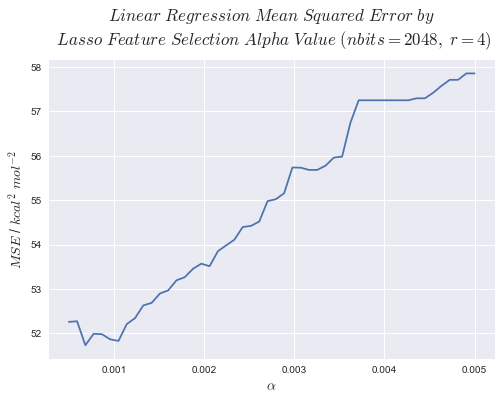

In [97]:
plt.style.use('seaborn')
plt.plot(index, MSE)
plt.ylabel('$MSE$ / $kcal^{2}$ $mol^{-2}$', fontsize = 14)
plt.xlabel(r'$\alpha$', fontsize = 14)
plt.title('$Linear$ $Regression$ $Mean$ $Squared$ $Error$ $by$ \n $Lasso$ $Feature$ $Selection$ $Alpha$ $Value$ $(nbits=2048,$ $r=4)$', fontsize = 17, y = 1.03)

In [98]:
morg_fp = [AllChem.GetMorganFingerprintAsBitVect(m, 4, nBits = 2048) for m in azo_data['mol']]

morg_fp_np = []
for fp in morg_fp:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    morg_fp_np.append(arr)

X = morg_fp_np
y = azo_data["E"].astype(float).tolist()
m = len(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lasso = SelectFromModel(linear_model.Lasso(normalize= True, alpha= 0.0007))
lasso.fit(X_train, y_train)
X_train = lasso.transform(X_train)
X_test = lasso.transform(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

(0.0, 20.0)

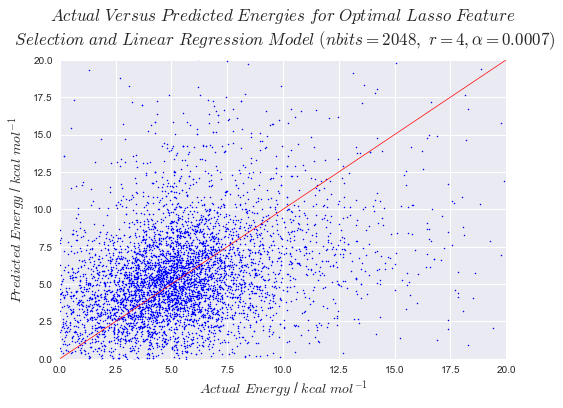

In [100]:
plt.style.use('seaborn')
plt.plot(y_test, y_predict, 'b.', markersize = 3)
plt.title('$Actual$ $Versus$ $Predicted$ $Energies$ $for$ $Optimal$ $Lasso$ $Feature$ \n $Selection$ $and$ $Linear$ $Regression$ $Model$ $(nbits=2048,$ $r=4, $' r'$ \alpha=0.0007)$', \
          fontsize = 17, y = 1.03)
plt.xlabel('$Actual$ $Energy$ / $kcal$ $mol^{-1}$',fontsize=14)
plt.ylabel('$Predicted$ $Energy$ / $kcal$ $mol^{-1}$',fontsize=14)
x = np.linspace(0,20)
plt.plot(x, x, 'r',linewidth=0.7)
plt.ylim([0, 20])
plt.xlim([0, 20])

In [102]:
print('Mean Squared Error:', sk.metrics.mean_squared_error(y_test, y_predict))
print('Mean Absolute Error:', sk.metrics.mean_absolute_error(y_test, y_predict))
print('Mean Absolute Value:', (np.sum(y_test)/np.size(y_test)))
print('Maximum Error:', sk.metrics.max_error(y_test, y_predict))
#print('Mean Poisson Deviance:', sk.metrics.mean_poisson_deviance(y_test, y_predict))
print((sk.metrics.mean_absolute_error(y_test, y_predict))*100/(np.sum(y_test)/np.size(y_test)))

Mean Squared Error: 51.81278648261313
Mean Absolute Error: 3.785578151258514
Mean Absolute Value: 5.460541777339284
Maximum Error: 176.8649529623905
69.32605418327343


In [107]:
MSE = []
alpha2 = []
index = [0.001, 0.005, 0.01, 0.02, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7]
for i in index:
    lso = Lasso(alpha=i)
    lso.fit(X_train, y_train)
    y_predict = lso.predict(X_test)
    MSE.append(sk.metrics.mean_squared_error(y_test, y_predict))
    alpha2.append(i)
min_index = MSE.index(np.min(MSE))
print('Minimum MSE:', np.min(MSE))
print('Optimum Alpha Value:', alpha2[min_index])

Minimum MSE: 51.07298870218755
Optimum Alpha Value: 0.05


Text(0.5, 1.03, '$Lasso$ $Model$ $Mean$ $Squared$ $Error$ $by$ $\\alpha$ $Value$ $(nbits=2048$, $r=4)$')

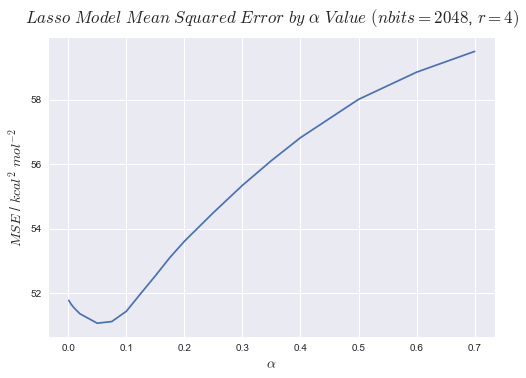

In [108]:
plt.style.use('seaborn')
plt.plot(index, MSE)
plt.ylabel('$MSE$ / $kcal^{2}$ $mol^{-2}$', fontsize = 14)
plt.xlabel(r'$\alpha$', fontsize = 14)
plt.title('$Lasso$ $Model$ $Mean$ $Squared$ $Error$ $by$ ' r'$\alpha$ ' '$Value$ $(nbits=2048$, $r=4)$', fontsize = 17, y = 1.03)

In [109]:
lso = Lasso(alpha=0.05)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)

(0.0, 20.0)

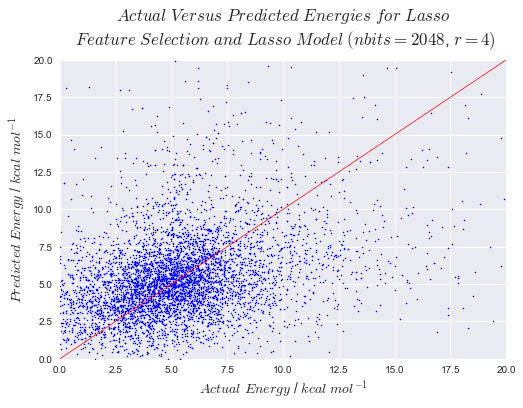

In [111]:
plt.style.use('seaborn')
plt.plot(y_test, y_predict, 'b.', markersize = 3)
plt.title('$Actual$ $Versus$ $Predicted$ $Energies$ $for$ $Lasso$ \n $Feature$ $Selection$ $and$ $Lasso$ $Model$ $(nbits=2048$, $r=4)$', \
          fontsize = 17, y = 1.03)
plt.ylabel('$Predicted$ $Energy$ / $kcal$ $mol^{-1}$',fontsize=14)
plt.xlabel('$Actual$ $Energy$ / $kcal$ $mol^{-1}$',fontsize=14)
x = np.linspace(0,20)
plt.plot(x, x, 'r', linewidth=0.7)
plt.ylim([0, 20])
plt.xlim([0, 20])

# Lasso

In [205]:
lso = Lasso(alpha=0.01)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)

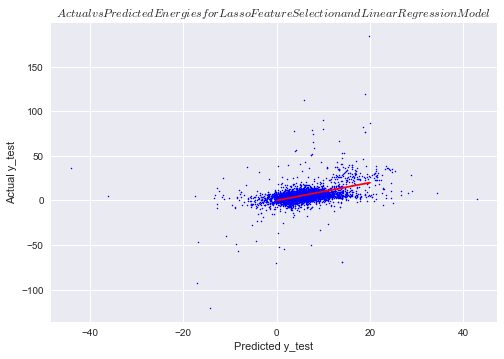

In [207]:
plt.style.use('seaborn')
plt.plot(y_predict, y_test, 'b.', markersize = 3)
plt.title(r'$Actual vs Predicted Energies for Lasso Feature Selection and Linear Regression Model$')
plt.xlabel('Predicted y_test')
plt.ylabel('Actual y_test')
x = np.linspace(0,20)
plt.plot(x, x, 'r')
#plt.ylim([0, 35])

In [208]:
print('Mean Squared Error:', sk.metrics.mean_squared_error(y_test, y_predict))
print('Mean Absolute Error:', sk.metrics.mean_absolute_error(y_test, y_predict))
print('Mean Absolute Value:', (np.sum(y_test)/np.size(y_test)))

Mean Squared Error: 54.851062298519466
Mean Absolute Error: 3.772641985597065
Mean Absolute Value: 5.460541777339284


# NN in Keras

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [113]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [115]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(16),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1),  
])

In [116]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt, metrics=['MeanSquaredError'])

In [133]:
history = model.fit(
      X_train, y_train,
      steps_per_epoch=12, batch_size=16,
      epochs=500, validation_split=0.33)

Train on 16841 samples, validate on 8295 samples
Epoch 1/500
  192/16841 [..............................] - ETA: 11:58 - loss: 24.6594 - MeanSquaredError: 24.6594 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 48/500


  192/16841 [..............................] - ETA: 11:02 - loss: 8.8710 - MeanSquaredError: 8.8710 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 95/500


  192/16841 [..............................] - ETA: 11:03 - loss: 19.6395 - MeanSquaredError: 19.6395 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 142/500


  192/16841 [..............................] - ETA: 11:05 - loss: 37.3730 - MeanSquaredError: 37.3730 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 189/500


  192/16841 [..............................] - ETA: 12:21 - loss: 38.7899 - MeanSquaredError: 38.7899 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 236/500


  192/16841 [..............................] - ETA: 10:59 - loss: 31.7379 - MeanSquaredError: 31.7379 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 283/500


  192/16841 [..............................] - ETA: 12:15 - loss: 9.6851 - MeanSquaredError: 9.6851 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 330/500


  192/16841 [..............................] - ETA: 11:14 - loss: 10.3313 - MeanSquaredError: 10.3313 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 377/500


  192/16841 [..............................] - ETA: 12:24 - loss: 27.6067 - MeanSquaredError: 27.6067 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 424/500


  192/16841 [..............................] - ETA: 10:55 - loss: 16.3487 - MeanSquaredError: 16.3487 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 471/500


  192/16841 [..............................] - ETA: 13:12 - loss: 5.5721 - MeanSquaredError: 5.5721 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00

Text(0.5, 0, '$Number$ $of$ $Epochs$')

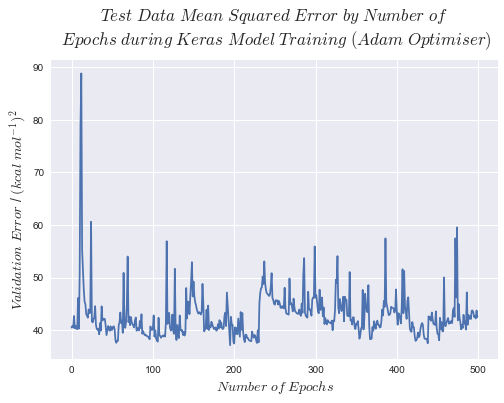

In [135]:
plt.style.use('seaborn')
plt.plot(history.history['val_loss'])
plt.title('$Test$ $Data$ $Mean$ $Squared$ $Error$ $by$ $Number$ $of$ \n $Epochs$ $during$ $Keras$ $Model$ $Training$ $(Adam$ $Optimiser)$', \
          fontsize = 17, y = 1.03)
plt.ylabel('$Validation$ $Error$ / $(kcal$ $mol^{-1})^{2}$', fontsize=14)
plt.xlabel('$Number$ $of$ $Epochs$', fontsize=14)

In [128]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(16),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1),  
])

opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt, metrics=['MeanSquaredError'])
history2 = model.fit(
      X_train, y_train,
      steps_per_epoch=12, batch_size=16,
      epochs=500, validation_split=0.33)

Train on 16841 samples, validate on 8295 samples
Epoch 1/500
  192/16841 [..............................] - ETA: 11:35 - loss: 43.1480 - MeanSquaredError: 43.1480 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 48/500


  192/16841 [..............................] - ETA: 12:38 - loss: 45.1373 - MeanSquaredError: 45.1373 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 95/500


  192/16841 [..............................] - ETA: 11:08 - loss: 34.4093 - MeanSquaredError: 34.4093 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 142/500


  192/16841 [..............................] - ETA: 11:27 - loss: 31.0172 - MeanSquaredError: 31.0172 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 189/500


  192/16841 [..............................] - ETA: 11:22 - loss: 38.0084 - MeanSquaredError: 38.0084 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 236/500


  192/16841 [..............................] - ETA: 11:17 - loss: 8.8659 - MeanSquaredError: 8.8659 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 283/500


  192/16841 [..............................] - ETA: 11:21 - loss: 55.2033 - MeanSquaredError: 55.2033 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 330/500


  192/16841 [..............................] - ETA: 11:18 - loss: 22.7104 - MeanSquaredError: 22.7104 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 377/500


  192/16841 [..............................] - ETA: 11:23 - loss: 20.6516 - MeanSquaredError: 20.6516 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 424/500


  192/16841 [..............................] - ETA: 11:21 - loss: 64.8846 - MeanSquaredError: 64.8846 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00Epoch 471/500


  192/16841 [..............................] - ETA: 11:21 - loss: 27.4380 - MeanSquaredError: 27.4380 - val_loss: 0.0000e+00 - val_MeanSquaredError: 0.0000e+00

Text(0.5, 0, '$Number$ $of$ $Epochs$')

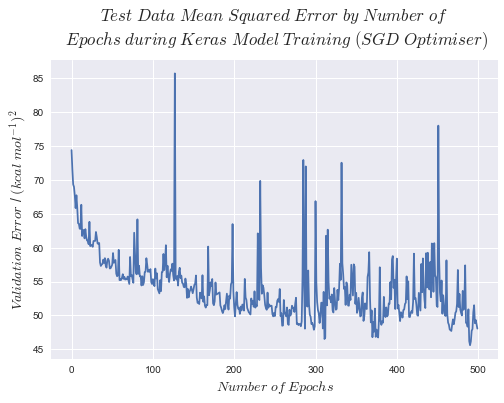

In [131]:
plt.style.use('seaborn')
plt.plot(history2.history['val_loss'])
plt.title('$Test$ $Data$ $Mean$ $Squared$ $Error$ $by$ $Number$ $of$ \n $Epochs$ $during$ $Keras$ $Model$ $Training$ $(SGD$ $Optimiser)$', \
          fontsize = 17, y = 1.03)
plt.ylabel('$Validation$ $Error$ / $(kcal$ $mol^{-1})^{2}$', fontsize=14)
plt.xlabel('$Number$ $of$ $Epochs$', fontsize=14)

# Hyperparameter of neural networks

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [137]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [138]:
index = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150]
batchsize = []
MSE = []

for i in index:

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(16),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1),  
    ])

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['MeanSquaredError'])

    model.fit(
          X_train, y_train,
          steps_per_epoch=12, batch_size=i,
          epochs=20)

    y_predict = model.predict(X_test)

    MSE.append(sk.metrics.mean_squared_error(y_test, y_predict))
    batchsize.append(i)

min_index = MSE.index(np.min(MSE))
print('Minimum MSE:', np.min(MSE))
print('Optimum Batch Size:', batchsize[min_index])

Train on 25136 samples
Epoch 1/20
  110/25136 [..............................] - ETA: 1:39 - loss: 272.3941 - MeanSquaredError: 272.3941Train on 25136 samples
Epoch 1/20
  165/25136 [..............................] - ETA: 57s - loss: 18.0961 - MeanSquaredError: 18.0961Train on 25136 samples
Epoch 1/20
  220/25136 [..............................] - ETA: 45s - loss: 89.6388 - MeanSquaredError: 89.6388  Train on 25136 samples
Epoch 1/20
  300/25136 [..............................] - ETA: 53s - loss: 34.8061 - MeanSquaredError: 34.8061- ETA: 52s - loss: 31.1742 - MeanSquaredError: 31.17Epoch 12/20


  300/25136 [..............................] - ETA: 47s - loss: 76.1274 - MeanSquaredError: 76.1274Train on 25136 samples
Epoch 1/20
  360/25136 [..............................] - ETA: 45s - loss: 36.4949 - MeanSquaredError: 36.4949Train on 25136 samples
Epoch 1/20
  420/25136 [..............................] - ETA: 39s - loss: 41.0613 - MeanSquaredError: 41.0613Train on 25136 samples
Epoch 1/20
  480/25136 [..............................] - ETA: 35s - loss: 74.8720 - MeanSquaredError: 74.8720Train on 25136 samples
Epoch 1/20
  540/25136 [..............................] - ETA: 27s - loss: 86.5850 - MeanSquaredError: 86.5850Epoch 4/20


  540/25136 [..............................] - ETA: 29s - loss: 51.4018 - MeanSquaredError: 51.4018Train on 25136 samples
Epoch 1/20
  600/25136 [..............................] - ETA: 32s - loss: 59.2668 - MeanSquaredError: 59.2668Train on 25136 samples
Epoch 1/20
  660/25136 [..............................] - ETA: 29s - loss: 63.8913 - MeanSquaredError: 63.8913Train on 25136 samples
Epoch 1/20
  720/25136 [..............................] - ETA: 28s - loss: 36.8900 - MeanSquaredError: 36.8900Epoch 16/20


  720/25136 [..............................] - ETA: 24s - loss: 40.2535 - MeanSquaredError: 40.2535Train on 25136 samples
Epoch 1/20
  780/25136 [..............................] - ETA: 26s - loss: 22.5661 - MeanSquaredError: 22.5661Train on 25136 samples
Epoch 1/20
  840/25136 [>.............................] - ETA: 21s - loss: 51.7760 - MeanSquaredError: 51.7760Train on 25136 samples
Epoch 1/20
  900/25136 [>.............................] - ETA: 24s - loss: 58.3228 - MeanSquaredError: 58.3228Train on 25136 samples
Epoch 1/20
  960/25136 [>.............................] - ETA: 21s - loss: 28.7733 - MeanSquaredError: 28.7733Epoch 7/20


  960/25136 [>.............................] - ETA: 21s - loss: 42.8182 - MeanSquaredError: 42.8182Train on 25136 samples
Epoch 1/20
 1020/25136 [>.............................] - ETA: 20s - loss: 38.9005 - MeanSquaredError: 38.9005Train on 25136 samples
Epoch 1/20
 1080/25136 [>.............................] - ETA: 20s - loss: 58.6154 - MeanSquaredError: 58.6154Train on 25136 samples
Epoch 1/20
 1140/25136 [>.............................] - ETA: 19s - loss: 34.1644 - MeanSquaredError: 34.1644Epoch 20/20


 1140/25136 [>.............................] - ETA: 18s - loss: 94.8701 - MeanSquaredError: 94.8701Train on 25136 samples
Epoch 1/20
 1200/25136 [>.............................] - ETA: 16s - loss: 36.3853 - MeanSquaredError: 36.3853Train on 25136 samples
Epoch 1/20
 1155/25136 [>.............................] - ETA: 15s - loss: 49.4522 - MeanSquaredError: 49.4522Train on 25136 samples
Epoch 1/20
 1266/25136 [>.............................] - ETA: 15s - loss: 39.7922 - MeanSquaredError: 39.7922Train on 25136 samples
Epoch 1/20
 1380/25136 [>.............................] - ETA: 17s - loss: 49.7889 - MeanSquaredError: 49.7889Epoch 11/20


 1380/25136 [>.............................] - ETA: 16s - loss: 36.9059 - MeanSquaredError: 36.9059Train on 25136 samples
Epoch 1/20
 1440/25136 [>.............................] - ETA: 14s - loss: 30.6979 - MeanSquaredError: 30.6979Train on 25136 samples
Epoch 1/20
 1500/25136 [>.............................] - ETA: 13s - loss: 26.7015 - MeanSquaredError: 26.7015Train on 25136 samples
Epoch 1/20
 1560/25136 [>.............................] - ETA: 12s - loss: 63.8261 - MeanSquaredError: 63.8261Train on 25136 samples
Epoch 1/20
 1620/25136 [>.............................] - ETA: 11s - loss: 53.1654 - MeanSquaredError: 53.1654Epoch 3/20


 1620/25136 [>.............................] - ETA: 16s - loss: 54.8586 - MeanSquaredError: 54.8586- ETA: 16s - loss: 53.3314 - MeanSquaredError: 53.331Train on 25136 samples
Epoch 1/20
 1680/25136 [=>............................] - ETA: 14s - loss: 33.0299 - MeanSquaredError: 33.0299Train on 25136 samples
Epoch 1/20
 1740/25136 [=>............................] - ETA: 12s - loss: 53.5986 - MeanSquaredError: 53.5986Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 13s - loss: 30.7794 - MeanSquaredError: 30.7794Epoch 14/20


 1800/25136 [=>............................] - ETA: 12s - loss: 43.9960 - MeanSquaredError: 43.9960Minimum MSE: 45.09942817299355
Optimum Batch Size: 150


Text(0.5, 1.03, '$Test$ $Set$ $Mean$ $Squared$ $Error$ $by$ $Keras$ $Model$ $Batch$ $Size$ \n  $Optimiser=RMSprop$')

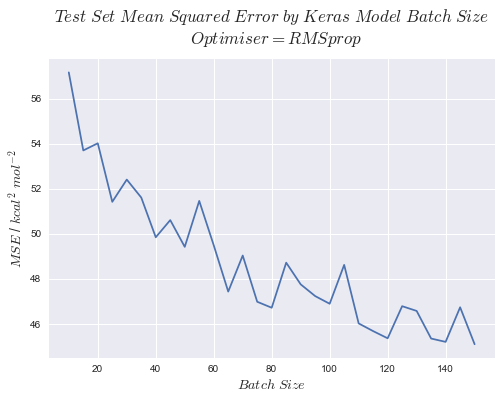

In [141]:
plt.style.use('seaborn')
plt.plot(index, MSE)
plt.ylabel('$MSE$ / $kcal^{2}$ $mol^{-2}$', fontsize = 14)
plt.xlabel('$Batch$ $Size$', fontsize = 14)
plt.title('$Test$ $Set$ $Mean$ $Squared$ $Error$ $by$ $Keras$ $Model$ $Batch$ $Size$ \n  $Optimiser=RMSprop$', \
fontsize = 17, y = 1.03)

In [144]:
index = [0.001,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055,0.06,0.065,0.07,0.075]
learnrate = []
MSE = []

for i in index:

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(16),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1),  
    ])

    opt = tf.keras.optimizers.RMSprop(learning_rate=i)
    model.compile(loss='mse', optimizer=opt, metrics=['MeanSquaredError'])

    model.fit(
          X_train, y_train,
          steps_per_epoch=12, batch_size=150,
          epochs=20)

    y_predict = model.predict(X_test)

    MSE.append(sk.metrics.mean_squared_error(y_test, y_predict))
    learnrate.append(i)

min_index = MSE.index(np.min(MSE))
print('Minimum MSE:', np.min(MSE))
print('Optimum Learning Rate:', learnrate[min_index])

Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 19s - loss: 34.0478 - MeanSquaredError: 34.0478Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 11s - loss: 55.9954 - MeanSquaredError: 55.9954Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 27s - loss: 35.7903 - MeanSquaredError: 35.7903Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 22s - loss: 83.1978 - MeanSquaredError: 83.19782 - ETA: 25s - loss: 95.2438 - MeanSquaredError: 95Epoch 11/20


 1800/25136 [=>............................] - ETA: 18s - loss: 60.1498 - MeanSquaredError: 60.1498Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 19s - loss: 62.6254 - MeanSquaredError: 62.6254Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 12s - loss: 40.6367 - MeanSquaredError: 40.6367Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 11s - loss: 73.0609 - MeanSquaredError: 73.0609Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 43s - loss: 9019.8807 - MeanSquaredError: 9019.8809   : 2:12 - loss: 53583.4181 - MeanSquaredErEpoch 2/20


 1800/25136 [=>............................] - ETA: 12s - loss: 82.3537 - MeanSquaredError: 82.3537Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 19s - loss: 45.8481 - MeanSquaredError: 45.8481Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 12s - loss: 49.5442 - MeanSquaredError: 49.5442Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 11s - loss: 54.5205 - MeanSquaredError: 54.5205Epoch 14/20


 1800/25136 [=>............................] - ETA: 12s - loss: 48.1155 - MeanSquaredError: 48.1155Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 13s - loss: 75.6177 - MeanSquaredError: 75.6177Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 17s - loss: 117.1652 - MeanSquaredError: 117.1652- ETA: 16s - loss: 118.8535 - MeanSquaredError: 118.853Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 14s - loss: 56.4368 - MeanSquaredError: 56.4368Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 13s - loss: 103.2586 - MeanSquaredError: 103.2586Epoch 5/20


 1800/25136 [=>............................] - ETA: 13s - loss: 61.5941 - MeanSquaredError: 61.5941Train on 25136 samples
Epoch 1/20
 1800/25136 [=>............................] - ETA: 12s - loss: 80.8054 - MeanSquaredError: 80.8054Minimum MSE: 45.06479551726732
Optimum Learning Rate: 0.001


Text(0.5, 1.03, '$Test$ $Set$ $Mean$ $Squared$ $Error$ $by$ $Keras$ $Model$ $Learning$ $Rate$ \n $(Optimiser=RMSprop$, $Batch$ $Size$ $= 150)$')

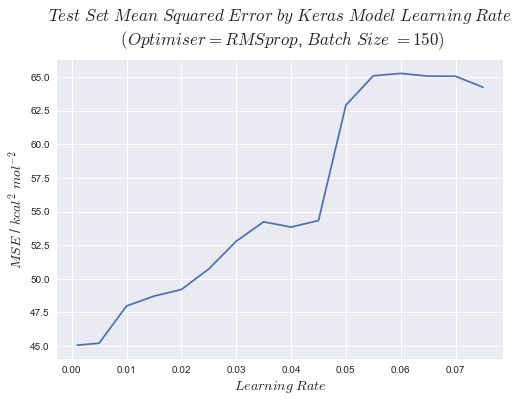

In [146]:
plt.style.use('seaborn')
plt.plot(index, MSE)
plt.ylabel('$MSE$ / $kcal^{2}$ $mol^{-2}$', fontsize = 14)
plt.xlabel('$Learning$ $Rate$', fontsize = 14)
plt.title('$Test$ $Set$ $Mean$ $Squared$ $Error$ $by$ $Keras$ $Model$ $Learning$ $Rate$ \n $(Optimiser=RMSprop$, $Batch$ $Size$ $= 150)$', \
fontsize = 17, y = 1.03)

(-10.0, 25.0)

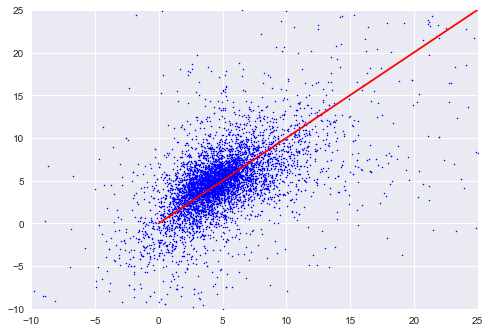

In [214]:
plt.style.use('seaborn')
plt.plot(model.predict(X_test),y_test,'b.', markersize=3)
x = np.linspace(0,30)
plt.plot(x, x, 'r')
plt.ylim([-10, 25])
plt.xlim([-10, 25])

In [215]:
print('Mean Squared Error:', sk.metrics.mean_squared_error(y_test, model.predict(X_test)))
print('Mean Absolute Error:', sk.metrics.mean_absolute_error(y_test, model.predict(X_test)))
print('Mean Absolute Value:', (np.sum(y_test)/np.size(y_test)))

Mean Squared Error: 45.09334883979104
Mean Absolute Error: 3.0982764946384673
Mean Absolute Value: 5.460541777339284
